In [2]:
import yaml
import pickle
import os
from pathlib import Path
import numpy as np
import pandas as pd
from ast import literal_eval
from mnitimescales import plots
import matplotlib.pyplot as plt

Inputs:

In [3]:
inputs_file = Path(os.path.abspath("")).joinpath("inputs.yaml")
with open(inputs_file, "r") as f:
    inputs = yaml.safe_load(f)

Files and paths:

In [5]:
base_path = Path(inputs["base_path"])
tau_path = base_path.joinpath(inputs["results_dir"], inputs["data_dir"], "Pats")

Functions:

In [27]:
def exp_decay(params, t):
    return params["a"] * (np.exp(-t / params["tau"]) + params["b"])

def rmse(y_data, y_fit):
    assert y_data.shape == y_fit.shape, "Inputs must be the same shape!"

    mse = np.mean((y_data[:, 1:] - y_fit[:, 1:]) ** 2, axis=1)

    return np.sqrt(mse)

## Gather data and compute RMSE

In [36]:
df_rmse = []

pats = [p.stem for p in tau_path.glob("*")]
for pat in pats:
    pat_path = tau_path.joinpath(pat)
    for i, stage in enumerate(["W", "N3", "R"]):
        # Load ACF
        file_name = pat + "_" + stage.lower() + ".pkl"
        try:
            with open(pat_path.joinpath(inputs["acf_dir"], file_name), "rb") as f:
                acf_pat_stage = pickle.load(f)
        except FileNotFoundError:
            continue

        # Load fit
        file_name = pat + "_" + stage + "_tau.csv"
        df_fit = pd.read_csv(
            pat_path.joinpath(inputs["acf_dir"], file_name),
            index_col=0,
        )
        df_fit[["tau", "a", "b"]] = df_fit.apply(
            lambda row: literal_eval(
                    " ".join(row["params"].split())
                    .replace("[ ", "[")
                    .replace(" ]", "]")
                    .replace(" ", ",")
                ),
                axis="columns",
                result_type='expand'
        )
        df_fit.drop(columns=["params"], inplace=True)

        # Compute RMSE
        y_fit = np.array(df_fit.apply(exp_decay, t=acf_pat_stage["lags"], axis=1).tolist())
        y_data = acf_pat_stage["acf"].mean(axis=0)
        rmse_pat_stage = rmse(y_data, y_fit)
        n = len(acf_pat_stage["chans"])
        df = pd.DataFrame(
            {"pat": [pat] * n,
             "chans": acf_pat_stage["chans"],
             "stage": [stage] * n, 
             "rmse": rmse_pat_stage}
            )
        df_rmse.append(df)

df_rmse = pd.concat(df_rmse, ignore_index=True)
df_rmse.head()

,pat,chans,stage,rmse
0,001,GD001Lc_11,W,0.071956
1,001,GD001Lc_12,W,0.085135
2,001,GD001Lc_13,W,0.071427
3,001,GD001Lc_14,W,0.133293
4,001,GD001Lo_1,W,0.068619


## Plot RMSEs

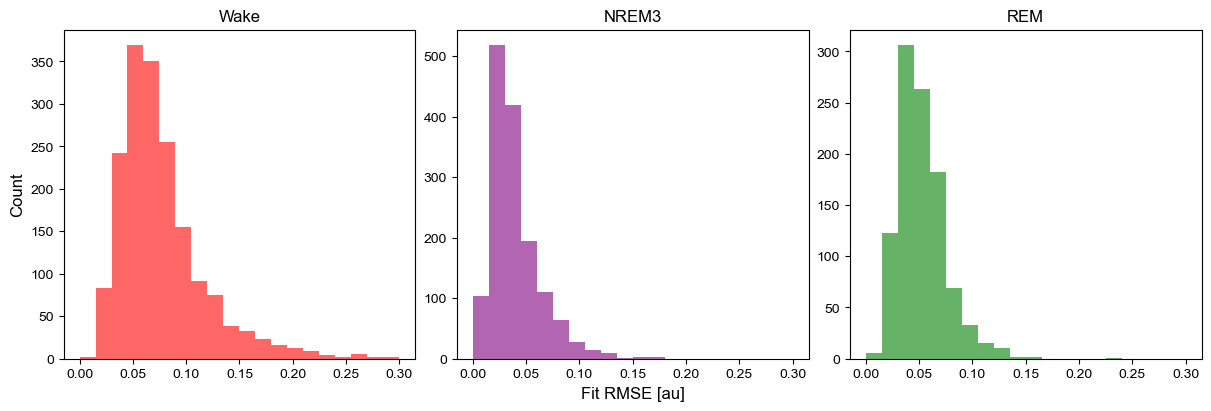

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), layout="constrained", sharex=True)

for i, stage in enumerate(inputs["stages"]):
    df_rmse_stage = df_rmse[df_rmse["stage"] == stage]
    axs[i].hist(df_rmse_stage["rmse"], bins=20, range=(0, 0.3),
                color=inputs["color_stages"][stage], alpha=0.6)
    axs[i].set_title(inputs["title_dict"][stage], fontsize=plots.fsize.TITLE_SIZE)
axs[1].set_xlabel("Fit RMSE [au]", fontsize=plots.fsize.LABEL_SIZE)
axs[0].set_ylabel("Count", fontsize=plots.fsize.LABEL_SIZE)
plt.show()

In [44]:
df_rmse[(df_rmse["stage"] == "W") & (df_rmse["rmse"] > 0.25)]

,pat,chans,stage,rmse
831,026,GD026Lm_8,W,0.261074
1292,039,GD039Lf_1,W,0.303173
1710,048,GD048Ls_1,W,0.289900
1711,048,GD048Ls_2,W,0.291482
1768,049,GD049Rw04,W,0.267545
2946,081,MD081LFus4,W,0.256064
3035,083,MM083ROs1,W,0.374785
3036,083,MM083ROs2,W,0.259198
3169,085,MM085LPCu4,W,0.270638
3339,089,MD089LHp9,W,0.258057
